In [80]:
import pandas as pd
import os
import numpy as np
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import fasttext
import csv
import datetime
from bs4 import BeautifulSoup
import re
import itertools
import emoji
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ammarahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read Data

In [2]:
path = "../Data Instagram/Labeled_instagram_posts_related_to_covid.xlsx"
df = pd.read_excel(path)
df['Contents'] = df['Contents'].astype(str)

## Translation and Language Detection

In [3]:
model_lang = fasttext.load_model('lid.176.ftz')
GT = GoogleTranslator(source='auto', target='en')

In [4]:
def get_lang(post):
    out = model_lang.predict(post.replace("\n",' '))  
    return out[0][0].split('__')[-1]

def translate(post):
    try:
        return GT.translate(post)
    except:
        return 'not translated'

#### Detect Languages

In [6]:
df['Lang'] = df['Contents'].apply(get_lang)

#### Translate Text

In [31]:
translated_text = []
for i,row in df.iterrows():
    if row['Lang']!='en':
        try:
            translated_text.append(GT.translate(row['Contents']))
        except:
            translated_text.append('could not translate')
    else:
        translated_text.append(row['Contents'])
        
    if i%100==0:
        print(i)

df['translated_text'] = translated_text

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600


In [41]:
df[df['translated_text'] == 'could not translate']

,imagename,postid,dataset,dataset.1,postdate,Contents,url,Q1_pertain_to_covid,Q2_cetegory,Q2A_Type of Human,...,Q9A_Asian responsible for the covid,Q10_solution_present,Q11_recommended_solution,misinformation,Q12 Presence of conspiracy theory,Q12-Others,Q13. Image of plague doctor costume,Note,Lang,translated_text
9067,CETKv6eg8JV,7813,second,3,2020-08-25,🖤 I remember the moment i fell for uhh!!!🥰💖💕._...,https://www.instagram.com/p/CETKv6eg8JV/,1,1,1,...,2,1,1,0,2,99,2.0,NaN,ru,could not translate


In [44]:
df.at[9067,'translated_text'] = df.at[9067,'Contents']

In [46]:
df.to_csv('../Data Instagram/translated_df.csv',index=False)

## Preprocess

In [52]:
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }


def load_dict_contractions_slangs():
    
    cont = {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "i'd":"i would",
        "i'll":"i will",
        "i'm":"i am",
        "i'm'a":"i am about to",
        "i'm'o":"i am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "i've":"i have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks",
        "rn":"right now",
        "atm": "at the moment",
        "idk": "i dont know",
        "cuz": "because",
        "bcuz": "because",
        "ur": "you are",
        "ly": "love you",
        "lol": "laugh out loud",
        "rofl": "rolling on floor laughing",
        "lmao": "laughing my ass off",
        "ok": "okay",
        "ty": "thank you",
        "fav": "favorite",
        "omg": "oh my god"
        }
    
    to_ret = {}
    for k,v in cont.items():
        key = k.lower().replace("'",'')
        to_ret[key] = v.lower()
        
    return to_ret


def strip_accents(text):
    if 'ø' in text or  'Ø' in text:
        #Do nothing when finding ø 
        return text   
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)


def tweet_cleaning_for_sentiment_analysis(tweet):    
    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
    #Special case not handled previously.
    tweet = tweet.replace('\x92',"'")
    #Removal of account
    tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)", " ", tweet).split())
    # removal of hashtag
    tweet = tweet.replace('#','')
    #Removal of address
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    #Lower case
    tweet = tweet.lower()
    # rempval of 'RT'
    tweet = tweet.replace('rt','')
    # Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    # removal of stop words
    tweet = ' '.join([word for word in tweet.split(' ') if word not in stop_words])
    # CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS_SLANGS = load_dict_contractions_slangs()
    tweet = tweet.replace("’","'").replace("'","")
    words = tweet.split()
    reformed = [CONTRACTIONS_SLANGS[word] if word in CONTRACTIONS_SLANGS else word for word in words]
    tweet = " ".join(reformed)

    # Standardizing words - lemmatization
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split(' ')]).lower()
    
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  
    words = tweet.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    tweet = " ".join(reformed)
    # replace emojis with desctiption - remove accents - remove underscores
    tweet = emoji.demojize(tweet).lower()
    tweet = strip_accents(tweet).lower()
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split()).replace('_',' ')
    
    # remove new line characters
    tweet = tweet.strip().replace('\\n',' ')
    
    # only keep alphabets
    tweet = ''.join([c for c in tweet if (c.isalpha() or c ==' ')]).strip()
    
    # rempove double spaces and triple spaces
    tweet = tweet.replace('   ',' ').replace('  ',' ')
    
    # one word replacements
    replacement_dict = {
        'u': 'you',
        'v': 'we',
        'r': 'are',
        'w': 'we',
        'n': 'and',
        'nd': 'and',
        '&': 'and',
        'xd': 'smiley'
    }
    
    tweet = ' '.join([replacement_dict[word] if word in replacement_dict else word for word in tweet.split(' ')])
    
    # removal of stop words
    tweet = ' '.join([word for word in tweet.split(' ') if word not in stop_words])

    return tweet
    

In [53]:
text = df['translated_text'].astype(str).apply(tweet_cleaning_for_sentiment_analysis).tolist()

## Predict

In [59]:
model = fasttext.load_model('fasttext_all.bin')

In [61]:
Y_pred = model.predict(text)
Y_pred = [x[0].split('_')[-1] for x in Y_pred[0]]

In [63]:
df['emotion_pred'] = Y_pred

In [122]:
df.to_csv('insta_data_predicted.csv',index=False)

## Check Correlation

In [65]:
plt.style.use('default')

In [67]:
# filter only those posts which have presence information
filtered_df = df[df['Q5_presence_asian'].notnull()]
filtered_df

,imagename,postid,dataset,dataset.1,postdate,Contents,url,Q1_pertain_to_covid,Q2_cetegory,Q2A_Type of Human,...,Q10_solution_present,Q11_recommended_solution,misinformation,Q12 Presence of conspiracy theory,Q12-Others,Q13. Image of plague doctor costume,Note,Lang,translated_text,emotion_pred
0,B-A5FIIIEKJ,5592,middle,2,2020-03-21,#covid #covid2020 #covidvirus #virus #coronava...,https://www.instagram.com/p/B-A5FIIIEKJ/,1,1,1,...,1,1,0,2,99,2.0,Stay home,en,#covid #covid2020 #covidvirus #virus #coronava...,anger
1,B-A74YQn_4a,5593,middle,2,2020-03-21,Well this is the final mural of my trip in Aus...,https://www.instagram.com/p/B-A74YQn_4a/,1,1,1,...,2,99,0,2,99,2.0,NaN,en,Well this is the final mural of my trip in Aus...,fear
4,B-AE1y3HD-Z,5550,middle,2,2020-03-21,EN MI DOMICILIO 🏡_x000D__x000D__x000D__x000D_\...,https://www.instagram.com/p/B-AE1y3HD-Z/,1,1,1,...,1,1,0,2,99,2.0,mask; Stay home,es,AT MY HOME 🏡_x000D__x000D__x000D__x000D_\n# st...,anger
9,B-AG5WYDjX_,5554,middle,2,2020-03-21,"#yo #coronavirus is winning! 11,949 and counti...",https://www.instagram.com/p/B-AG5WYDjX_/,1,2,2,...,1,1,0,2,99,2.0,Social distancing,en,"#yo #coronavirus is winning! 11,949 and counti...",fear
13,B-AJa0eH4cs,5555,middle,2,2020-03-21,"""Our New Normal"" - Artwork for Turbulent Times...",https://www.instagram.com/p/B-AJa0eH4cs/,1,1,2,...,1,1,0,2,99,2.0,NaN,nl,"""Our New Normal"" - Artwork for Turbulent Times...",anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,CEZUc37n171,8347,second,3,2020-08-27,• The police raided 2 brothels running out in ...,https://www.instagram.com/p/CEZUc37n171/,1,2,1,...,1,1,0,2,99,2.0,NaN,en,• The police raided 2 brothels running out in ...,anger
9633,CEZUTUBAZP4,8346,second,3,2020-08-27,"Neste momento de isolamento, o trabalho remoto...",https://www.instagram.com/p/CEZUTUBAZP4/,1,2,1,...,1,1,0,2,99,2.0,NaN,pt,"In this moment of isolation, remote working an...",fear
9635,CEZVPmSJSOA,8348,second,3,2020-08-27,"Palopo,-- Walikota Palopo, Drs. HM. Judas Amir...",https://www.instagram.com/p/CEZVPmSJSOA/,1,2,1,...,1,1,0,2,99,2.0,NaN,id,"Palopo,-- Mayor of Palopo, Drs. HM. Judas Amir...",fear
9636,CEZWG3YAdXJ,8350,second,3,2020-08-27,Does convalescent plasma work for COVID? Maybe...,https://www.instagram.com/p/CEZWG3YAdXJ/,1,2,1,...,2,99,0,2,99,2.0,NaN,en,Does convalescent plasma work for COVID? Maybe...,fear


In [119]:
cnts = []
for emotion in ['sadness','fear','anger','joy']:
    temp_cnts = []
    for pr in [1,2]:
        cnt = sum(((filtered_df['emotion_pred'] == emotion) & (filtered_df['Q5_presence_asian'] == pr)).tolist())
        temp_cnts.append(cnt)
    cnts.append(temp_cnts)
count_df = pd.DataFrame(cnts,columns = ['not present','present'],index = ['sadness','fear','anger','joy'])
count_df

,not present,present
sadness,74,233
fear,393,916
anger,144,361
joy,113,425


In [ ]:
P(anger | EA) = p(anger,EA) / p(EA)

<AxesSubplot:>

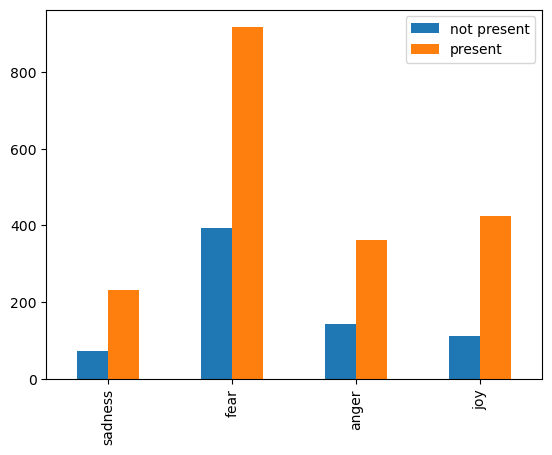

In [120]:
count_df.plot.bar()